In [1]:
import copy
import numpy as np
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from matplotlib.patches import Rectangle
from optical import rectangular_sw_substrate, rectangular_lw_substrate

def plot_delta(ax, delta):
    sc = ax.scatter(bertin_center_x, bertin_center_y, c=delta)
    bar = fig.colorbar(sc, ax=ax)
    bar.set_label('Sag difference [nm]')
    ax.set_aspect('equal')
    ax.set_xlabel('Center x (mm)')
    ax.set_ylabel('Center y (mm)')
    # Draw aperture of rectangular substrate
    rect = Rectangle((substrate_center.aperture.dx - substrate_center.aperture.x_width / 2,
                      substrate_center.aperture.dy - substrate_center.aperture.y_width / 2),
                      substrate_center.aperture.x_width,
                      substrate_center.aperture.y_width,
                      color='red', fill=None)
    ax.add_patch(rect)

In [2]:
np.set_printoptions(precision=6, suppress=True)
substrates_ega = [rectangular_lw_substrate, rectangular_sw_substrate]
for substrate in substrates_ega:
    print(f'=== {substrate.name} substrate ============')
    print('EGA to native')
    print(substrate.surface.rotation_matrix())
    print('Native to EGA')
    print(substrate.surface.inverse_rotation_matrix())
    print('')

=== Rectangular LW substrate ============
EGA to native
[[ 0.999909  0.000082 -0.013497 -0.000166]
 [ 0.        0.999982  0.006047 -2.0386  ]
 [ 0.013497 -0.006047  0.999891  0.012328]]
Native to EGA
[[ 0.999909  0.        0.013497 -0.      ]
 [ 0.000082  0.999982 -0.006047  2.038637]
 [-0.013497  0.006047  0.999891 -0.      ]]

=== Rectangular SW substrate ============
EGA to native
[[  0.99606   -0.004875   0.088543 -31.855804]
 [  0.         0.998488   0.054977 -15.18078 ]
 [ -0.088678  -0.05476    0.994554   1.215498]]
Native to EGA
[[ 0.99606  -0.       -0.088678 31.838092]
 [-0.004875  0.998488 -0.05476  15.069078]
 [ 0.088543  0.054977  0.994554  2.446336]]



# Validation of EGA sag maps with Bertin

The requirements document by IAS ```SOLC-IAS-RS-004_v1.0_substrates_specifications``` uses two reference frames for each surface (LW and SW):
* the 'native' reference frame of the surface, *i.e.* the one centered on the surface vertex.
* the EGA frame, common to both surfaces, centered in the middle of the bonding joint.
The document gives the transformation matrices to convert coordinates from one system to the other. They are given by:

These matrices are computed using the Zemax convention when the order flag is set to zero (default), *i.e.*  translations first, then rotations. The rotations are defined as intrinsic in order XYZ (see manual page 326).
*Bertin uses the same conventions: translations first, then rotations*.

Bertin uses a reference frame centered on the substrate top surface, hereafter center frame. The objective of the present notebook is to compare and validate the sag values computed by Bertin in the center frame of reference prior to fabrication.

We derive equivalent transformation matrices between the native and the center frames. **These can be used to compute the sag in Bertin's system of coordinates and with their method (see below)**.

Irrespective of the reference frame used, IAS and Bertin compute the sag is different ways: IAS transforms coordinates from the desired frame to the native one then computes the surface, while Bertin defines the surface in its native frame then transforms to the desired one.

We will first validate the equivalence of the surfaces defined in the EGA and in the center frame, then simulate the way Bertin computes the sag and check tha the results are equivalent.

For their computations, Bertin uses a set of points across the substrate: four corners and a cross

In [3]:
# values in [mm]
bertin_center_x = [0, -30, -20, -10, 10, 20, 30, 0, 0, 0, 0, 0, 0, 0, 0, -30, -30, 30, 30]
bertin_center_y = [0, 0, 0, 0, 0, 0, 0, -40, -30, -20, -10, 10, 20, 30, 40, -40, 40, 40, -40]

For best accuracy at the interpolation stage, we compute sags on a finer cartesian grid (resolution ```dx``` and  ```dy```) that comprises the points used by Bertin. The comparisons will be made at the points used by Bertin.

In [4]:
dx = dy = 0.2  # [mm] spatial resolution for all sag computations
n_margin = 5 # number of points of margin used to minimize edge effects when interpolating
x_min, x_max = min(bertin_center_x) - n_margin * dx, max(bertin_center_x) + n_margin * dx
y_min, y_max = min(bertin_center_y) - n_margin * dy, max(bertin_center_y) + n_margin * dy
nx = int((x_max - x_min) / dx)
nx += (nx + 1) % 2
ny = int((y_max - y_min) / dy)
ny += (ny + 1) % 2
# Regular x & y vectors in the frame of the substrate center, using n_margin points of margin
# The vectors are designed to contain the position values used by Bertin.
# The values are the same for both substrates because they are relative to the substrate center
x_bertin_resampled = np.linspace(x_min, x_max, nx)
y_bertin_resampled = np.linspace(y_min, y_max, ny)
# indices of the original Bertin coordinates in the new, finely gridded, vectors
# will be used to extract comparison values from the sag tables at the locations used by Bertin
ix = [int((len(x_bertin_resampled) - 1) * (bx - x_min) / (x_max - x_min)) for bx in bertin_center_x]
iy = [int((len(y_bertin_resampled) - 1) * (by - y_min) / (y_max - y_min)) for by in bertin_center_y]

## Comparison of the two surfaces definitions (wr EGA & wrt center frame)

We define two new substrates with optical surfaces defined in the respective center frames. This is achieved by translating the surfaces defined in the EGA frame by the distances between the vertices and the substrate center. In z, this requires to compute the sag of the surfaces in the EGA frame at the substrate center. By definition, **the resulting surfaces have zero sag at the substrate center**.

In [5]:
rectangular_lw_substrate_center = copy.deepcopy(rectangular_lw_substrate)
rectangular_sw_substrate_center = copy.deepcopy(rectangular_sw_substrate)
substrates_center = [rectangular_lw_substrate_center, rectangular_sw_substrate_center]

for substrate_ega, substrate_center in zip(substrates_ega, substrates_center):
    substrate_center.aperture.dx = 0 # By definition of substrate defined wrt its center
    substrate_center.aperture.dy = 0
    # By definition aperture is centered on substrate
    substrate_center.surface.dx = substrate_ega.surface.dx - substrate_ega.aperture.dx
    substrate_center.surface.dy = substrate_ega.surface.dy - substrate_ega.aperture.dy
    # Compute sag at center in EGA coordinates
    # Use the built-in substrate grid to achieve better precision by interpolation with neighbors
    j_mid, i_mid = substrate_ega.grid()[0].shape[0] // 2, substrate_ega.grid()[0].shape[1] // 2
    # Sag at center of substrate in EGA coordinates
    substrate_center.surface.dz = substrate_ega.surface.dz - substrate_ega.sag()[j_mid, i_mid]

We verify that the two substrate definitions are equivalent by comparing the sags

Rectangular LW : PV=0.01408 nm, RMS=0.00290 nm
Rectangular SW : PV=0.16887 nm, RMS=0.03091 nm


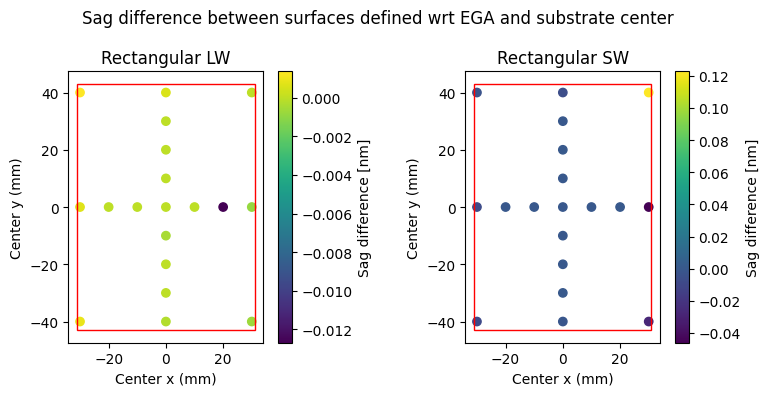

In [6]:
fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
fig.suptitle('Sag difference between surfaces defined wrt EGA and substrate center')

limits = x_min, x_max, y_min, y_max
grid_center = substrate_center.grid(nx, ny, limits)

for substrate_ega, substrate_center, ax in zip(substrates_ega, substrates_center, axes):
    # Translate the substrate points to the substrate frame (EGA & center) and define the corresponding grid
    # EGA
    limits = (x_min + substrate_ega.aperture.dx, x_max + substrate_ega.aperture.dx,
              y_min + substrate_ega.aperture.dy, y_max + substrate_ega.aperture.dy)
    grid_ega = substrate_ega.grid(nx, ny, limits)
    sag_ega = substrate_ega.sag(grid_ega)[(iy, ix)]  # compute sag and select at the locations defined by Bertin
    # Center
    sag_center = substrate_center.sag(grid_center)[(iy, ix)]
    delta = sag_ega - sag_center  # sag difference
    # Compensate sag difference at substrate center between the two definitions
    # The sag at the center is 0 by definition for the substrates defined in the center frame
    delta -= substrate_ega.surface.dz - substrate_center.surface.dz
    delta *= 1e6 # convert to [nm]

    print(f'{substrate_ega.name} : PV={np.nanmax(delta) - np.nanmin(delta):.5f} nm, RMS={np.nanstd(delta):.5f} nm')
    plot_delta(ax, delta)
    ax.set_title(substrate_ega.name)

The sag differences are sub-nanometer for both substrates: **the two definitions are thus equivalent**. The differences are suspected to be caused by the different interpolations.

For reference, we give here the sag values in the substrate center frames:

In [7]:
for substrate in substrates_center:
    print(f'=== {substrate.name} substrate ============')
    sag = substrate.sag(grid_center)[iy, ix]
    print('x y z')
    for x, y, z in zip(bertin_center_x, bertin_center_y, sag):
        print(f'{x:.0f} {y:.0f} {z:.7f}')
    print('')

=== Rectangular LW substrate ============
x y z
0 0 0.0000000
-30 0 1.8910862
-20 0 1.0701315
-10 0 0.4398673
10 0 -0.2497068
20 0 -0.3094334
30 0 -0.1793035
0 -40 1.4284521
0 -30 0.7870325
0 -20 0.3351984
0 -10 0.0728642
0 10 0.1166317
0 20 0.4228410
0 30 0.9187656
0 40 1.6045992
-30 -40 3.3212453
-30 40 3.4986574
30 40 1.4243239
30 -40 1.2481411

=== Rectangular SW substrate ============
x y z
0 0 0.0000000
-30 0 -0.5830981
-20 0 -0.5818373
-10 0 -0.3876789
10 0 0.5819304
20 0 1.3589536
30 0 2.3320236
0 -40 0.5235325
0 -30 0.1027821
0 -20 -0.1248718
0 -10 -0.1592331
0 10 0.3532352
0 20 0.9009873
0 30 1.6438802
0 40 2.5826477
-30 -40 -0.0658464
-30 40 1.9958257
30 40 4.9265968
30 -40 2.8588720



## Simulation of Bertin's way of computing the sag

In order to do that we compare the sags computed in the center frame using the two methods (IAS & Bertin).

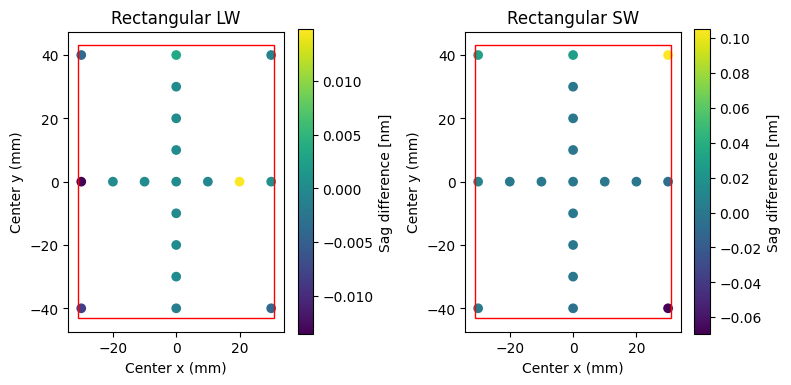

In [8]:
fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))

for substrate_center, ax in zip(substrates_center, axes):
    # Create a surface identical to that of the substrate,
    # but defined in its 'native' coordinates, ie with no shift and no tilt
    native_surface = copy.deepcopy(substrate_center.surface)
    native_surface.dx, native_surface.dy, native_surface.dz = 0, 0, 0
    native_surface.alpha, native_surface.beta, native_surface.gamma = 0, 0, 0

    # define a regular grid in the surface native coordinates with enough margin to cover the substrate
    x_half_width = int(substrate_center.aperture.x_width / 2 + abs(substrate_center.surface.dx) + 2 * dx)
    y_half_width = int(substrate_center.aperture.y_width / 2 + abs(substrate_center.surface.dy) + 2 * dy)
    nx = int(2 * x_half_width / dx)
    nx += (nx + 1) % 2
    ny = int(2 * y_half_width / dy)
    ny += (ny + 1) % 2
    x_surface_native, y_surface_native = np.meshgrid(np.linspace(-x_half_width, x_half_width, nx),
                                                     np.linspace(-y_half_width, y_half_width, ny))
    # compute the corresponding sag
    z_surface_native = native_surface.sag((x_surface_native, y_surface_native))

    # Transform the coordinates from surface to substrate center coordinates
    xyz = np.stack((x_surface_native.ravel(),
                    y_surface_native.ravel(),
                    z_surface_native.ravel(),
                    np.ones(x_surface_native.size)))
    x_surface_center, y_surface_center, z_surface_center = substrate_center.surface.inverse_rotation_matrix() @ xyz

    # Interpolation at Bertin' locations
    xy = (grid_center[0].flatten(), grid_center[1].flatten())
    z = griddata((x_surface_center, y_surface_center), z_surface_center, xy, rescale=True, method='cubic').reshape(grid_center[0].shape)[iy, ix]

    delta = substrate_center.sag(grid_center)[iy, ix] - z
    delta *= 1e6 # convert to [nm]
    plot_delta(ax, delta)
    ax.set_title(substrate_center.name)

The sag differences are sub-nanometer for both substrates: **the two ways are thus equivalent**. The differences are suspected to be caused by the different interpolations.

The transformation matrices from the native frames to the substrate center frames are given by

In [9]:
for substrate in substrates_center:
    print(f'=== {substrate.name} substrate ============')
    print('Center frame to native')
    print(substrate.surface.rotation_matrix())
    print('Native to center frame')
    print(substrate.surface.inverse_rotation_matrix())
    print('')

=== Rectangular LW substrate ============
Center frame to native
[[  0.999909   0.000082  -0.013497 -11.040121]
 [  0.         0.999982   0.006047  -2.03705 ]
 [  0.013497  -0.006047   0.999891   0.119668]]
Native to center frame
[[ 0.999909  0.        0.013497 11.0375  ]
 [ 0.000082  0.999982 -0.006047  2.038637]
 [-0.013497  0.006047  0.999891 -0.256341]]

=== Rectangular SW substrate ============
Center frame to native
[[  0.99606   -0.004875   0.088543 -20.825612]
 [  0.         0.998488   0.054977 -15.158318]
 [ -0.088678  -0.05476    0.994554   0.643065]]
Native to center frame
[[ 0.99606  -0.       -0.088678 20.800592]
 [-0.004875  0.998488 -0.05476  15.069078]
 [ 0.088543  0.054977  0.994554  2.037766]]



The position of the substrate center in the native frame can be obtained by

In [10]:
for substrate in substrates_center:
    print(f'=== {substrate.name} substrate ============')
    x, y, z = substrate.surface.rotation_matrix()[:, 3]
    print(f'Substrate center at x={x:.4f} mm, y={y:.4f} mm, z={z:.4f} mm in surface native coordinates')
    print('')

=== Rectangular LW substrate ============
Substrate center at x=-11.0401 mm, y=-2.0370 mm, z=0.1197 mm in surface native coordinates

=== Rectangular SW substrate ============
Substrate center at x=-20.8256 mm, y=-15.1583 mm, z=0.6431 mm in surface native coordinates



These values are **different** from those listed in columns H and T of the file ```ComparaisonSAG.xlsx```. Conversely, the values given in that file are *exactly* the coordinates of the surface vertex expressed in the substrate center frame.

One can also obtain the Euler angles corresponding to the native to substrate center frame transformation matrix:

In [11]:
for substrate in substrates_center:
    print(f'=== {substrate.name} substrate ============')
    rotation = Rotation.from_matrix(substrate.surface.inverse_rotation_matrix()[:, 0:3])
    angles = rotation.as_euler('xyz', degrees=True)
    print(f'Angles : alpha={angles[0]:.5f}°, beta={angles[1]:.5f}° gamma={angles[2]:.5f}°')
    print('')

=== Rectangular LW substrate ============
Angles : alpha=0.34653°, beta=0.77333° gamma=0.00468°

=== Rectangular SW substrate ============
Angles : alpha=3.16398°, beta=-5.07982° gamma=-0.28043°



Finally, we simulate the sag computed by Bertin using two rotations only, with angles resulting from a fit of the sag provided by IAS.

In [12]:
sw_angles = [3.141628, -5.084720, 0]  # degrees
lw_angles = [0.346669, 0.773625, 0]   # degrees

The following does not work. I can' reproduce the sag differences computed by Bertin in columns I and U, which means that I don't understand the way they were computed (as I thought from the above).

-3.021414204175639e-07 6.046283655406404e-12 0.00016303587235965602
1.3760950847919095e-05 -9.561887705637925e-12 0.003993167926117998


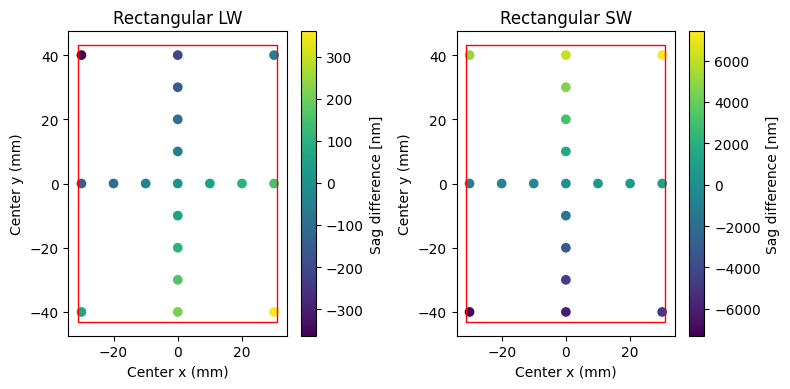

In [13]:
fig, axes = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))

for substrate_center, angles, ax in zip(substrates_center, [lw_angles, sw_angles], axes):

    origin_x, origin_y, origin_z = substrate_center.surface.rotation_matrix()[:, 3]
    rotation = Rotation.from_euler('xyz', (angles[0], angles[1], angles[2]), degrees=True).as_matrix()
    translation = np.array([[1, 0, 0, -origin_x],
                            [0, 1, 0, -origin_y],
                            [0, 0, 1, -origin_z]])
    inverse_rotation_matrix = rotation @ translation

    # Create a surface identical to that of the substrate,
    # but defined in its 'native' coordinates, ie with no shift and no tilt
    native_surface = copy.deepcopy(substrate_center.surface)
    native_surface.dx, native_surface.dy, native_surface.dz = 0, 0, 0
    native_surface.alpha, native_surface.beta, native_surface.gamma = 0, 0, 0

    # define a regular grid in the surface native coordinates with enough margin to cover the substrate
    x_half_width = int(substrate_center.aperture.x_width / 2 + abs(substrate_center.surface.dx) + 2 * dx)
    y_half_width = int(substrate_center.aperture.y_width / 2 + abs(substrate_center.surface.dy) + 2 * dy)
    nx = int(2 * x_half_width / dx)
    nx += (nx + 1) % 2
    ny = int(2 * y_half_width / dy)
    ny += (ny + 1) % 2
    x_surface_native, y_surface_native = np.meshgrid(np.linspace(-x_half_width, x_half_width, nx),
                                                     np.linspace(-y_half_width, y_half_width, ny))
    # compute the corresponding sag
    z_surface_native = native_surface.sag((x_surface_native, y_surface_native))

    # Transform the coordinates from surface to substrate center coordinates
    xyz = np.stack((x_surface_native.ravel(),
                    y_surface_native.ravel(),
                    z_surface_native.ravel(),
                    np.ones(x_surface_native.size)))
    # x_surface_center, y_surface_center, z_surface_center = substrate_center.surface.inverse_rotation_matrix() @ xyz
    # print(substrate_center.surface.inverse_rotation_matrix())
    x_surface_center, y_surface_center, z_surface_center = inverse_rotation_matrix @ xyz

    # Interpolation at Bertin' locations
    xy = (grid_center[0].flatten(), grid_center[1].flatten())
    z = griddata((x_surface_center, y_surface_center), z_surface_center, xy, rescale=True, method='cubic').reshape(grid_center[0].shape)[iy, ix]

    delta = substrate_center.sag(grid_center)[iy, ix] - z
    delta *= 1e6 # convert to [nm]
    plot_delta(ax, delta)
    ax.set_title(substrate_center.name)
    print(np.mean(delta.data) / 1e6, np.median(delta.data) / 1e6, np.std(delta.data) / 1e6)

# Annex: angles

(X, Y, Z) refers to the EGA Csys

($\eta_x$, $\eta_y$, $\eta_z$) refers to the LW Csys

($\xi_x$, $\xi_y$, $\xi_z$) refers to the SW Csys

## LW

### Angles between axes of EGA Csys and LW Csys
-Tx=89.22666°

-Ty=90.34647°

-Tz=0.84741°

### Angles projected on the EGA axes
-Plan XY: angle (X, $\eta_x$)=0.00468°

-Plan XY: angle (Y, $\eta_y$)=0.00000°

-Plan YZ: angle (Y, $\eta_y$)=0.34650°

-Plan YZ: angle (Z, $\eta_z$)=-0.34650°

-Plan XZ: angle (X, $\eta_x$)=-0.77333°

-Plan XZ: angle (Z, $\eta_z$)=0.77336°

## SW

### Angles between axes of EGA Csys and SW Csys

-Tx=95.08753°

-Ty=93.13911°

-Tz=5.98239°

### Angles projected on the EGA axes
-Plan XY: angle (X, $\xi_x$)=-0.28043°

-Plan XY: angle (Y, $\xi_y$)=-0.00000°

-Plan YZ: angle (Y, $\xi_y$)=3.15154°

-Plan YZ: angle (Z, $\xi_z$)=-3.15154°

-Plan XZ: angle (X, $\xi_x$)=5.07988°

-Plan XZ: angle (Z, $\xi_z$)=-5.09520°